# Neural inference for neurotransmission recovery models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
import xarray as xr

from enum import IntEnum
from typing import Union
from torchaudio.functional import convolve

# Local import
from include import neural_net
%matplotlib inline

## Load animal data

In [2]:
# Load the current data, which has 3000 time steps and is animal-specific
times = torch.from_numpy(np.load("../../Projects/Parameter_estimation_nn/calcium_rre/data/times.npy")).float()
currents = dict((f"animal{i}", torch.from_numpy(np.load(f"../../Projects/Parameter_estimation_nn/calcium_rre/data/Current_data_animal{i}.npy")).float()) for i in range(1, 6))

[Text(0.5, 0, '$t \\ [s]$')]

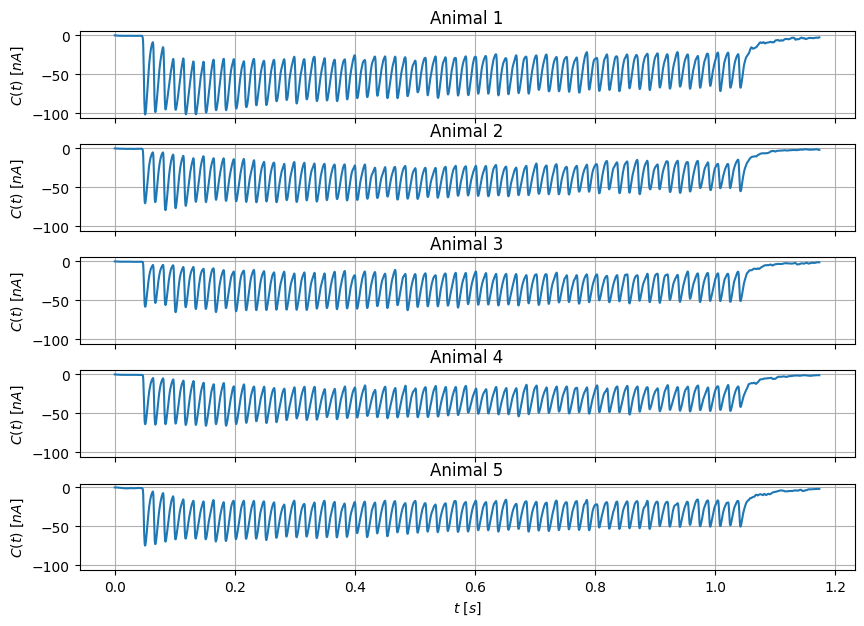

In [3]:
# Plot the currents for each animal
fig, axs = plt.subplots(nrows=5, figsize=(10, 7), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.3))
for i in range(1, 6):
    axs[i-1].plot(times, currents[f"animal{i}"] * 10**9)
    axs[i-1].grid()
    axs[i-1].set(title=f"Animal {i}", ylabel='$C(t) \ [nA]$')
axs[-1].set(xlabel='$t \ [s]$')

## Model parameters from the previous calibration

In [4]:
# Animal-calibrated parameters using method II
ANIMAL_PARAMS = {
    "animal1": dict(N=334,  g_V=2.5,    g_P=94,     k_R=15.2,   n_v=15,     L=1.7,  m1=40.6,   m2=7.1e-5),
    "animal2": dict(N=250,  g_V=0.9,    g_P=93.6,   k_R=5.8,    n_v=31,     L=1.7,  m1=9.9,    m2=1.1e-8),
    "animal3": dict(N=172,  g_V=2.7,    g_P=160.6,  k_R=28.9,   n_v=17,     L=1.5,  m1=8.6,    m2=2.1e-4),
    "animal4": dict(N=230,  g_V=2.0,    g_P=97.2,   k_R=8.9,    n_v=18,     L=1.6,  m1=12.2,   m2=3.1e-6),
    "animal5": dict(N=248,  g_V=1.9,    g_P=76.8,   k_R=13.9,   n_v=18,     L=1.6,  m1=22.0,   m2=1.7e-3),
}

# Array of spike heights used for k_F
A = torch.cat([
    torch.tensor([1398.0, 1420.0, 1438.0, 1454.0, 1467.0, 1478.0, 1487.0, 1495.0,
                  1502.0, 1507.0, 1512.0, 1515.0, 1519.0, 1521.0, 1524.0, 1525.0,
                  1527.0, 1528.0, 1530.0, 1531.0, 1532.0, 1532.0, 1533.0, 1533.0,
                  1534.0, 1534.0, 1535.0, 1535.0, 1535.0, 1535.0]),
    torch.tensor([1536]).repeat(11),
    torch.tensor([1537]).repeat(19)]
).float()

# General parameters for model functions. All parameters are given in s, Hz, and Ampere
GENERAL_PARAMS = {
    "impulse_function": dict(A = -6.229e-6, B = 2.7e-9, t0 = 0.0, tau_r = 10.6928, tau_df = 1.5e-3, tau_ds = 2.8e-3),
    "k_F": dict(m0 = 1, sigma = 1.25e-4, f_s = 60, A = A),
    "k_U": dict(k_min = 2.0e-8, k_max = 60, m3 = 3.3e4, m4 = 1.4e-3)
}

## Model ODE

In [5]:
# Define an enum for the parameters and compartments so we are sure to always index in a consistent way
class Parameters(IntEnum):
    R = 0
    U = 1
    F = 2
    g_V = 3
    g_P = 4
    n_v = 5
    N = 6

class Compartments(IntEnum):
    V = 0
    W_v = 1
    W_p = 2
    R = 3
    p = 4

In [6]:
# ODE to generate the data X and solve the ode
def solve_ODE(*, init_state: torch.Tensor,
                 k_R: torch.Tensor,
                 k_F: torch.Tensor,
                 k_U: torch.Tensor,
                 g_P: torch.Tensor,
                 g_V: torch.Tensor,
                 num_steps: int,
                 dt,
                 **__
) -> torch.Tensor:

    """ Forward Euler solver for the recovery model.

    :param init_state: Initial state from which to solve the ODE
    :param k_R: constant release rate
    :param k_F: time-dependent fusion rate
    :param k_U: time-dependent separation rate
    :param g_P: constant recovery rate
    :param g_V: constant recovery rate
    :param num_steps: number of steps L to iterate
    :param dt: time differential
    :param __: other parameters (ignored)
    :return: a time series of the comparments, of shape (L + 1, 7)
    """

    #  Start from initial state
    data = [init_state]

    # Iterate ODE
    for t in range(num_steps):
        data.append(
            data[-1] + torch.stack([

                    - k_R * data[-1][Compartments["V"].value] * data[-1][Compartments["p"].value] + g_V * data[-1][Compartments["W_v"].value] + k_U[t] * data[-1][Compartments["R"].value],

                    k_F[t] * data[-1][Compartments["R"].value] - g_V * data[-1][Compartments["W_v"].value],

                    k_F[t] * data[-1][Compartments["R"].value] - g_P * data[-1][Compartments["W_p"].value],

                    k_R * data[-1][Compartments["V"].value] * data[-1][Compartments["p"].value] - (k_F[t] + k_U[t]) * data[-1][Compartments["R"].value],

                    - k_R * data[-1][Compartments["V"].value] * data[-1][Compartments["p"].value] + g_P * data[-1][Compartments["W_p"].value] + k_U[t] * data[-1][Compartments["R"].value]
                ]) * dt
        )

    # Return the time series
    return torch.stack(data)

## Impulse function

In [7]:
# Impulse function (eq. A1), in seconds, used to calculate the current
def impulse_function(_t, *, A, B, t0, tau_r, tau_df, tau_ds, **__) -> torch.Tensor:
    _t = -(_t - t0)
    return A * (1 - torch.exp(_t / tau_r)) * (B * torch.exp(_t / tau_df) + (1-B) * torch.exp(_t / tau_ds))

[None, Text(0.5, 0, 'ms'), Text(0, 0.5, 'nA')]

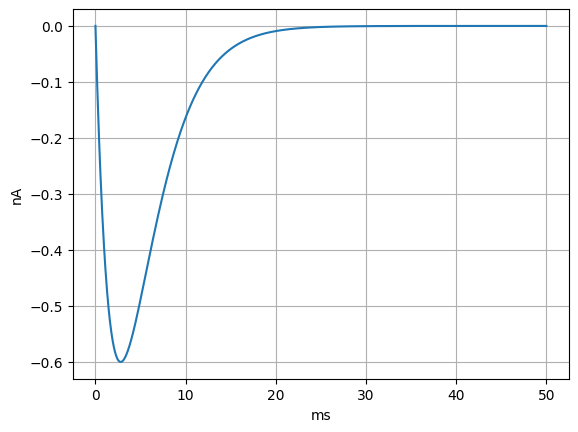

In [8]:
# Plot the impulse function
fig, ax = plt.subplots()
ax.plot(torch.linspace(0, 50, 1000), impulse_function(torch.linspace(0, 0.05, 1000), **GENERAL_PARAMS['impulse_function']) * 10**9)
ax.grid()
ax.set(xscale='linear', xlabel='ms', ylabel='nA')

## Function to calculate the current

In [9]:
# Current: derived by convolution
def calculate_current(*, R, k_F, g, N, dt, **__):

    """ Calculates the current by convolving the average rate of fusion events with the impulse function (g)

    :param R: number of release vesicles
    :param k_F: time-dependent fusion rate
    :param g: impulse function
    :param N: number of active zones/scaling factor
    :param dt: time differential
    :param __: other parameters (ignored)
    :return: the current over time
    """

    # Convolve the derivative of F with impulse function. The full convolution is calculated and then truncated to the support of R
    return convolve(k_F * R, N*g, mode='full')[:len(R)] * dt

## Original $k_F$ and $k_U$ estimates

In [10]:
# K function (eqs. 11-13 in the paper)
def k_F_original(_t, *, L, m0, m1, m2, sigma, f_s, A, **__) -> torch.Tensor:

    # Baseline function
    f0 = m0 * (10 ** (L * (1 - torch.exp(-m1 * (_t - m2)))))

    # Add Gaussian spikes
    f_gamma = torch.zeros_like(f0)
    for i in range(1, 61):
        f_gamma_temp = A[i-1] * torch.exp(-0.5 * ((_t - _t[torch.argmin(abs(_t-(i/f_s)))]) ** 2) / (sigma ** 2))
        f_gamma += f_gamma_temp

    # Return sum of both
    return f0 + f_gamma

# U function (eq. 14)
def k_U_original(_t, *, k_min, k_max, m3, m4, **__):
    return k_max * (1-torch.sigmoid(m3 * (_t - m4))) + k_min

[Text(0, 0.5, '$k_U \\ [Hz]$')]

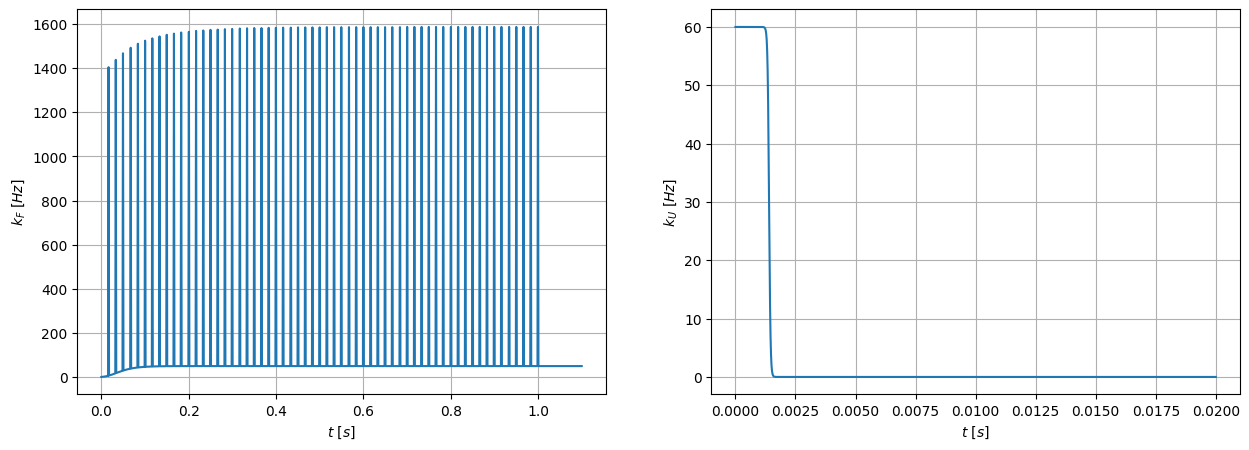

In [11]:
# Plot the functions for an example animal
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].plot(torch.linspace(0, 1.1, 1000), k_F_original(torch.linspace(0, 1.1, 1000), **ANIMAL_PARAMS['animal1'], **GENERAL_PARAMS["k_F"]))
axs[1].plot(torch.linspace(0, 0.02, 1000), k_U_original(torch.linspace(0, 0.02, 1000), **GENERAL_PARAMS["k_U"]))
for ax in axs:
    ax.set(xlabel='$t \ [s]$')
    ax.grid()
axs[0].set(ylabel='$k_F \ [Hz]$')
axs[1].set(ylabel='$k_U \ [Hz]$')

## Calculate the initial condition $X(t=0)$ from the parameters

In [12]:
# Calculate the initial condition from the parameters
def initial_condition(*, n_v: torch.Tensor, n_s: torch.Tensor = torch.tensor(1.0), k_F: torch.Tensor, k_U: torch.Tensor, k_R: torch.Tensor, g_P: torch.Tensor = None, g_V: torch.Tensor = None):

    """ Returns the initial condition as a function of the parameters. This is done by finding a vector from the kernel of the transition matrix
    that satisfies the constraints V + R + W_V = n_v and P + R + W_P = n_s = 1.

    :param n_v: number of vesicles
    :param n_s: number of sites (=1)
    :param k_F: constant fusion rate at time t0.
    :param k_U: separation rate at time t0
    :param k_R: reaction constant
    :param g_P: recovery constant. If k_F = 0, this is not needed
    :param g_V: recovery constant. If k_F = 0, this is not needed
    :return: the initial state of shape (5, )
    """

    init_state = torch.zeros(5)

    # Special case of k_F = 0
    if k_F == 0:
        _p = (n_s + n_v + k_U / k_R) / 2
        _q = n_v*n_s
        init_state[Compartments["R"].value] = _p - torch.sqrt(_p**2 - _q)
        init_state[Compartments["V"].value] = n_v - init_state[Compartments["R"].value]
        init_state[Compartments["W_v"].value] = 0
        init_state[Compartments["W_p"].value] = 0
        init_state[Compartments["p"].value] = n_s - init_state[Compartments["R"].value]

    else:
        # Coefficients of the full equation
        a_1 = k_F / g_V + 1
        a_2 = k_R / (k_F + k_U)
        a_3 = k_F / g_P

        _p = 1/(a_1 * a_2) + n_v / a_1 - a_3 + n_s # This is -p already, so no sign needed below
        _q = (n_v * n_s) / a_1 - (n_v * a_3) / a_1

        # Only the smaller root guarantees a valid solution
        lambda_1 = _p/2 - torch.sqrt((_p/2)**2 - _q)

        # Fill initial state
        init_state = torch.zeros(5)
        init_state[Compartments["R"].value] = lambda_1
        init_state[Compartments["W_p"].value] = (k_F / g_P) * lambda_1
        init_state[Compartments["W_v"].value] = (k_F / g_V) * lambda_1
        init_state[Compartments["p"].value] = n_s - init_state[Compartments["R"].value] - init_state[Compartments["W_p"].value]
        init_state[Compartments["V"].value] = n_v - init_state[Compartments["R"].value] - init_state[Compartments["W_v"].value]

    return init_state

## Check this function indeed produces valid initial states

In [13]:
for i in range(1000):

    # Case for k_F > 0
    g_P = 20*torch.rand(1, )
    n_v = n_v=100*torch.rand(1,)
    _init_state = initial_condition(n_v=n_v, n_s=1, g_P=g_P, k_F=torch.rand(1, )*g_P, g_V = 10*torch.rand(1, ), k_U = 10*torch.rand(1, ), k_R = 10 * torch.rand(1, ))
    assert all(_init_state >=0)
    assert _init_state[Compartments["R"]] <= 1
    assert abs(_init_state[Compartments["V"].value] + _init_state[Compartments["W_v"].value] + _init_state[Compartments["R"].value]- n_v.flatten()) < 1e-5
    assert abs(_init_state[Compartments["p"].value] + _init_state[Compartments["W_p"].value] + _init_state[Compartments["R"].value]- 1) < 1e-5

    # Case for k_F == 0
    n_v = 100*torch.rand(1,)
    _init_state = initial_condition(n_v=n_v, n_s=1, g_P=g_P, k_F=0, g_V = 10*torch.rand(1, ), k_U = 10*torch.rand(1, ), k_R = 10 * torch.rand(1, ))
    assert all(_init_state >=0)
    assert _init_state[Compartments["R"]] <= 1
    assert _init_state[Compartments["W_v"]] + _init_state[Compartments["W_p"]] == 0
    assert abs(_init_state[Compartments["V"].value] + _init_state[Compartments["W_v"].value] + _init_state[Compartments["R"].value]- n_v.flatten()) < 1e-5
    assert abs(_init_state[Compartments["p"].value] + _init_state[Compartments["W_p"].value] + _init_state[Compartments["R"].value]- 1) < 1e-5

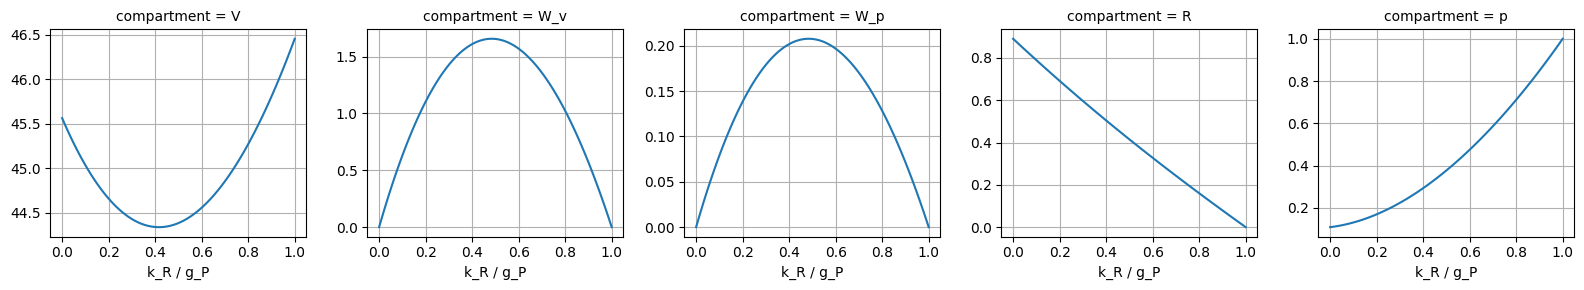

In [14]:
# Plot the compartments as a function of k_F / g_P. For k_F = 0, we have R = 1; for k_F = g_P, R goes to 0.
g_P = 20*torch.rand(1, )
n_v = 100*torch.rand(1,)
g_V = 10*torch.rand(1, )
k_U = 10*torch.rand(1, )
k_R = 10 * torch.rand(1, )

fg = xr.DataArray([initial_condition(n_v=n_v, n_s=1, g_P=g_P, k_F=l*g_P, k_U=k_U, k_R=k_R, g_V=g_V) for l in torch.linspace(0, 1, 100)], dims=['k_R / g_P', 'compartment'], coords={'k_R / g_P': torch.linspace(0, 1, 100), 'compartment': [e.name for e in Compartments]}).plot(x='k_R / g_P', col='compartment', sharey=False)
for ax in fg.axs.flatten():
    ax.grid()

## Generate ODE data from the original parameters

In [15]:
animal = "animal2"

# Recreate the calibrated data
dt = times.diff().mean()
print(f"dt: {dt}")
# Just run from 0 to t=1
start, stop = 0, torch.argmin(abs(times-1))
num_steps = stop-start

# Initial steady state from quadratic equation
init_state = initial_condition(n_v=ANIMAL_PARAMS[animal]['n_v'], n_s=torch.tensor(1.0), k_U=k_U_original(times, **GENERAL_PARAMS['k_U'])[0], k_R = ANIMAL_PARAMS[animal]['k_R'], k_F=torch.tensor(0.0))

# Stack the true parameters
true_params = torch.stack([
    ANIMAL_PARAMS[animal]["k_R"] * torch.ones(len(times)),
    k_U_original(times, **GENERAL_PARAMS["k_U"]),
    k_F_original(times, **GENERAL_PARAMS["k_F"], **ANIMAL_PARAMS[animal]),
    ANIMAL_PARAMS[animal]["g_V"] * torch.ones(len(times)),
    ANIMAL_PARAMS[animal]["g_P"] * torch.ones(len(times)),
    ANIMAL_PARAMS[animal]["n_v"] * torch.ones(len(times)),
    ANIMAL_PARAMS[animal]["N"] * torch.ones(len(times)),
]).transpose(1, 0)[start:stop]

# Generate ODE data using the original parameters
X = solve_ODE(k_U = k_U_original(times, **GENERAL_PARAMS["k_U"]),
              k_F = k_F_original(times, **GENERAL_PARAMS["k_F"], **ANIMAL_PARAMS[animal]),
              k_R = ANIMAL_PARAMS[animal]['k_R'],
              n_v = torch.tensor(ANIMAL_PARAMS[animal]['n_v']),
              n_s = torch.tensor(1.0),
              g_P=ANIMAL_PARAMS[animal]['g_P'],
              g_V=ANIMAL_PARAMS[animal]['g_V'],
              num_steps=num_steps,
              init_state=init_state,
              dt=dt,
              )
n_ves, n_sites = X[:, [Compartments["R"].value, Compartments["W_v"].value, Compartments["V"].value]].sum(dim=1)[:-1].reshape(-1, 1), X[:, [Compartments["R"].value, Compartments["p"].value, Compartments["W_p"].value]].sum(dim=1)[:-1].reshape(-1, 1)

dt: 0.0003912137181032449


## Plot results

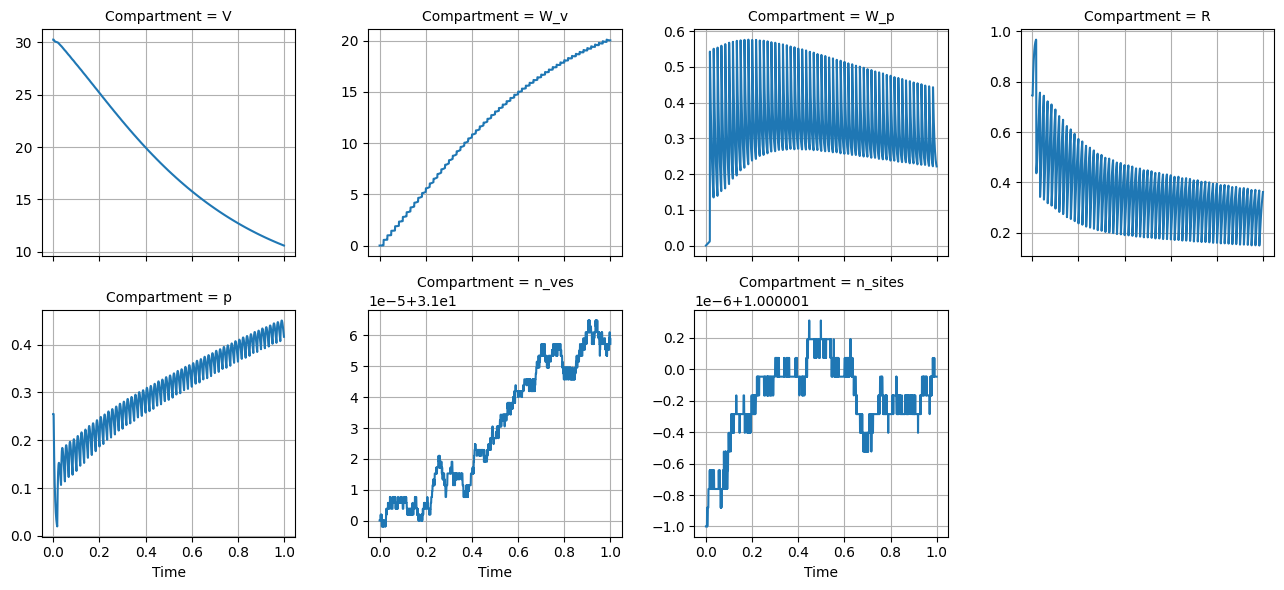

In [16]:
# Calculate current
g = impulse_function(times, **GENERAL_PARAMS['impulse_function'])
C = calculate_current(R=X[:, Compartments["R"].value][:-1], k_F = true_params[:, Parameters["F"].value], g=g, N=ANIMAL_PARAMS[animal]["N"], dt=dt)

# Plot the results
fg = xr.DataArray(np.hstack([X[:-1], n_ves, n_sites]),
             dims=["Time", "Compartment"],
             coords={"Time": times[start:stop], "Compartment": [e.name for e in Compartments] + ['n_ves'] + ['n_sites']}
             ).plot(col="Compartment", sharey=False, col_wrap=4)
for ax in fg.axs.flatten():
    ax.grid()

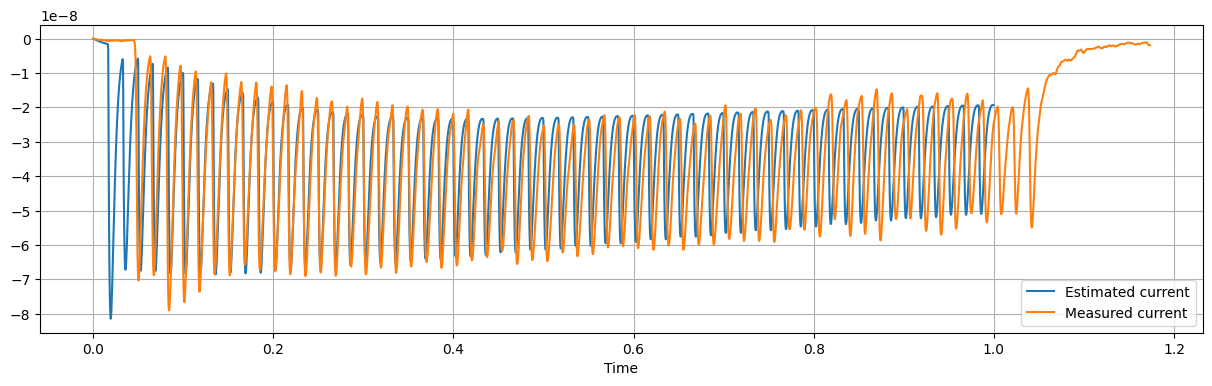

In [17]:
# Plot the estimated and measured current
fig, ax = plt.subplots(figsize=(15, 4), sharex=True)
xr.DataArray(C[start:stop], dims=["Time"], coords={"Time": times[start:stop]}).plot(label="Estimated current", ax=ax)
ax.grid()
ax.plot(times, currents[animal], label="Measured current")
ax.legend()

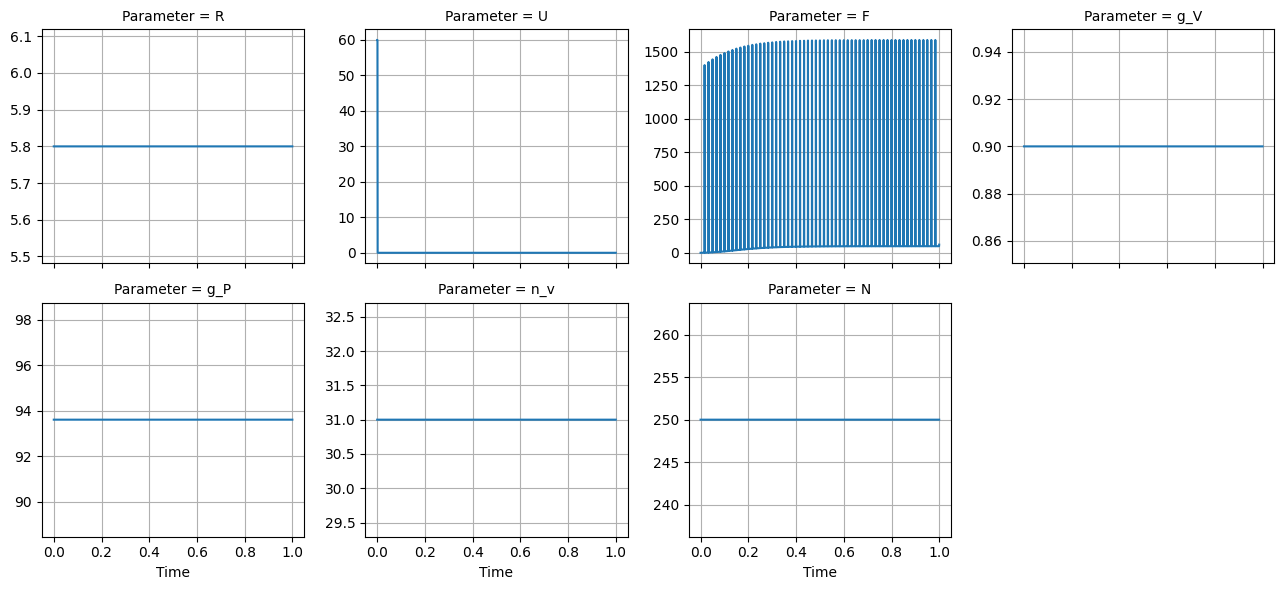

In [18]:
# Plot the estimated parameters
fg = xr.DataArray(true_params, dims = ["Time", "Parameter"],
             coords= {"Time": times[start:stop], "Parameter": [e.name for e in Parameters]}).plot(col="Parameter", sharey=False, col_wrap=4)
for ax in fg.axs.flatten():
    ax.grid()

# Neural parameter calibration
## Select a training period and train on all animal datasets simultaneously

In [19]:
# Training period
training_start, training_stop = 0, 1000

C_scale = 1e8

# Scale the training data by 10**8 for better performance
C_train = torch.stack([c[training_start:training_stop] * C_scale for c in currents.values()])
g_train = g[training_start:training_stop]

C_train.shape

torch.Size([5, 1000])

In [22]:
# Initialise the neural network
NN = neural_net.NeuralNet(
    input_size = 2, # Two time series points
    output_size = 7, # Number of parameters to leanr: k_R, k_U, k_F, g_V, g_P, N, n_v
    num_layers=7,
    nodes_per_layer={"default": 30},
    activation_funcs={"default": "softplus"},
    learning_rate=0.0001, # small learning rate for numerical stability
    optimizer='Adam',
    biases={"default": None}
)

# Store the training loss
loss_ts = []

In [23]:
# Single training epoch
def epoch(dsets, batch_size: int = 5):

    loss = torch.tensor(0.0, requires_grad=True)
    epoch_averaged_err = 0

    # Iterate over the training datasets and perform a gradient descent step every batch size steps
    for i, training_X in enumerate(dsets):

        # Make a parameter prediction
        predicted_params = NN(torch.hstack([training_X[:-1], training_X[1:]]))

        # Calculate the initial state
        _init_state = initial_condition(k_R = predicted_params[0, Parameters["R"].value],
                                        k_U = predicted_params[0, Parameters["U"].value],
                                        k_F = torch.min(predicted_params[0, Parameters["F"].value],
                                                        0.99*predicted_params[:, Parameters["g_P"].value].mean()
                                                        ), # to ensure numerical stability
                                        g_V = predicted_params[:, Parameters["g_V"].value].mean(),
                                        g_P = predicted_params[:, Parameters["g_P"].value].mean(),
                                        n_v = predicted_params[:, Parameters["n_v"].value].mean(),
                                        n_s = torch.tensor(1.0))

        # Generate a time series. Constant parameters are calculated from the mean of the parameter time series.
        predicted_time_series = solve_ODE(init_state=_init_state,
                                          k_R = predicted_params[:, Parameters["R"].value].mean(),
                                          k_U = predicted_params[:, Parameters["U"].value],
                                          k_F = predicted_params[:, Parameters["F"].value],
                                          g_V = predicted_params[:, Parameters["g_V"].value].mean(),
                                          g_P = predicted_params[:, Parameters["g_P"].value].mean(),
                                          num_steps=len(predicted_params),
                                          dt=dt)
        # Calculate the current
        predicted_current = calculate_current(R=predicted_time_series[:, Compartments["R"].value][:-1],
                                              k_F=predicted_params[:, Parameters["F"].value],
                                              dt=dt,
                                              g=g_train,
                                              N=predicted_params[:, Parameters["N"].value].mean())

        # Store error
        err = torch.nn.functional.mse_loss(predicted_current * C_scale, C_train[i][:-1])
        epoch_averaged_err += err.detach().numpy()
        loss = loss + err

        # Penalise variance of all parameters except k_U and k_F to make them constant
        for param in ["R", "g_V", "g_P", "N", "n_v"]:
           loss = loss + abs(predicted_params[:, Parameters[param].value].diff()).mean() / 10 #/ abs(predicted_params[:, Parameters[param].value].mean())

        # Gradient descent step
        if ((i > 0) and (i % batch_size) == 0) or (i >= dsets.shape[0]-1):
            loss.backward()

            # Clip the gradients to prevent large oscillations
            torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm=1)

            # Step
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            loss = torch.tensor(0.0, requires_grad=True)

    return epoch_averaged_err / C_train.shape[0]

In [44]:
for i in (pbar := tqdm.trange(1000)):
    _l = epoch(C_train.reshape((*C_train.shape, 1)))
    loss_ts.append(_l)
    pbar.set_description( f"Current loss: {_l}")

Current loss: 0.37804678082466125:  17%|█▋        | 171/1000 [02:39<12:54,  1.07it/s]


KeyboardInterrupt: 

## Plot the results

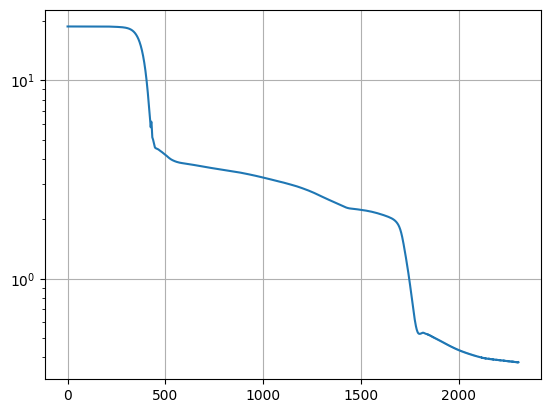

In [45]:
plt.plot(loss_ts)
plt.yscale('log')
plt.grid()

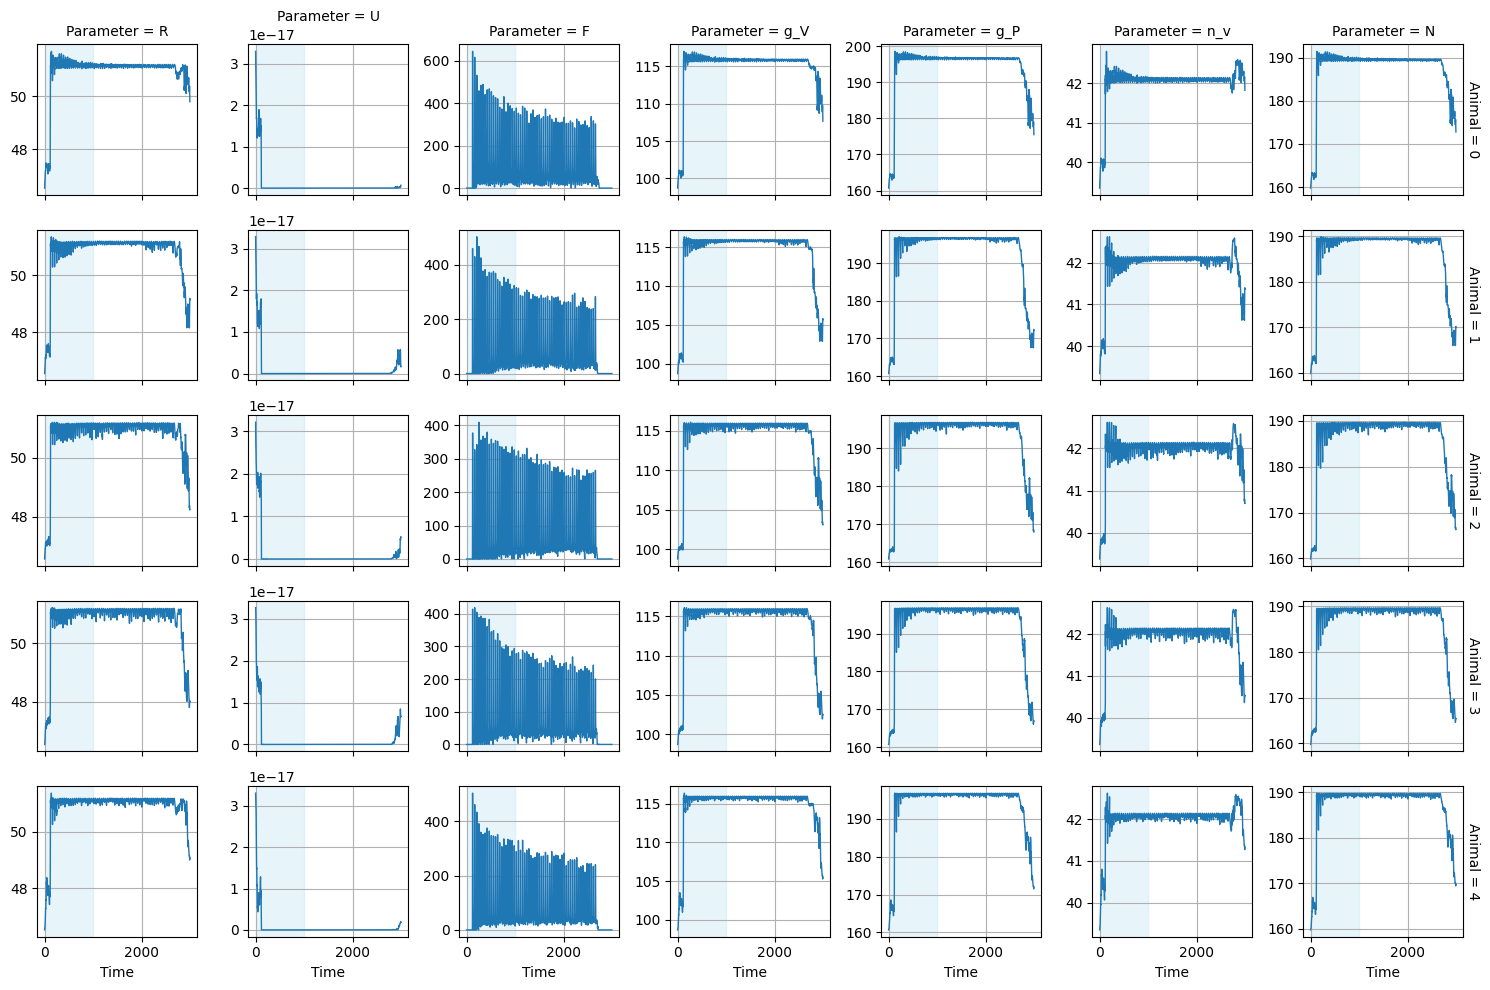

In [50]:
# Plot the parameters
predicted_params = torch.stack([NN(10**8 * torch.hstack([dset.reshape(-1, 1)[:-1], dset.reshape(-1, 1)[1:]])).detach() for dset in currents.values()])
fg = xr.DataArray(predicted_params, dims=["Animal", "Time", "Parameter"], coords={"Parameter": [e.name for e in Parameters]}).plot(
    row="Animal", col="Parameter", lw=1, sharey=False, sharex=True, figsize=(15, 10))
for ax in fg.axs.flatten():
    ax.grid()
    ax.axvspan(training_start, training_stop, color='skyblue', zorder=-1, alpha=0.2, label='Training period')

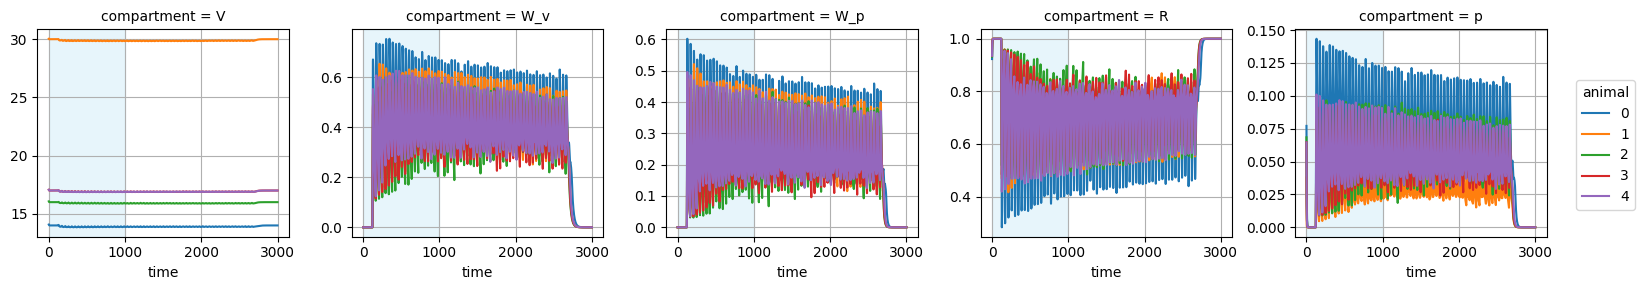

In [51]:
# Plot the predicted time series
pred_X = []
for a in range(5):
    _init_state = initial_condition(k_R = predicted_params[a, 0, Parameters["R"].value],
                                    k_U = predicted_params[a, 0, Parameters["U"].value],
                                    k_F = torch.min(predicted_params[a, 0, Parameters["F"].value], 0.99*predicted_params[a][:, Parameters["g_P"].value].mean()), # to ensure numerical stability
                                    g_V = predicted_params[a, :, Parameters["g_V"].value].mean(),
                                    g_P = predicted_params[a, :, Parameters["g_P"].value].mean(),
                                    n_v = predicted_params[a, :, Parameters["n_v"].value].mean(),
                                    n_s = torch.tensor(1.0))
    # Initial steady state from quadratic equation
    _init_state = initial_condition(n_v=ANIMAL_PARAMS[f"animal{a+1}"]['n_v'],
                                    n_s=torch.tensor(1.0),
                                    k_U=k_U_original(times, **GENERAL_PARAMS['k_U'])[0],
                                    k_R = predicted_params[a, :, Parameters["R"].value].mean(),#ANIMAL_PARAMS[f"animal{a+1}"]['k_R'],
                                    k_F=torch.tensor(0.0))
    # Generate a time series. Constant parameters are calculated from the mean of the parameter time series.
    pred_X.append(solve_ODE(init_state=_init_state,
                            k_R = predicted_params[a, :, Parameters["R"].value].mean(),
                            k_U = predicted_params[a, :, Parameters["U"].value],
                            k_F = predicted_params[a, :, Parameters["F"].value],
                            g_V = predicted_params[a, :, Parameters["g_V"].value].mean(),
                            g_P = predicted_params[a, :, Parameters["g_P"].value].mean(),
                            num_steps=len(predicted_params[a]),
                            dt=dt))
pred_X = torch.stack(pred_X)
fg = xr.DataArray(pred_X, dims=['animal', 'time', 'compartment'], coords={'compartment': [e.name for e in Compartments]}).plot(
    x='time', hue='animal', col='compartment', sharey=False
)
for ax in fg.axs.flatten():
    ax.grid()
    ax.axvspan(training_start, training_stop, color='skyblue', zorder=-1, alpha=0.2, label='Training period')

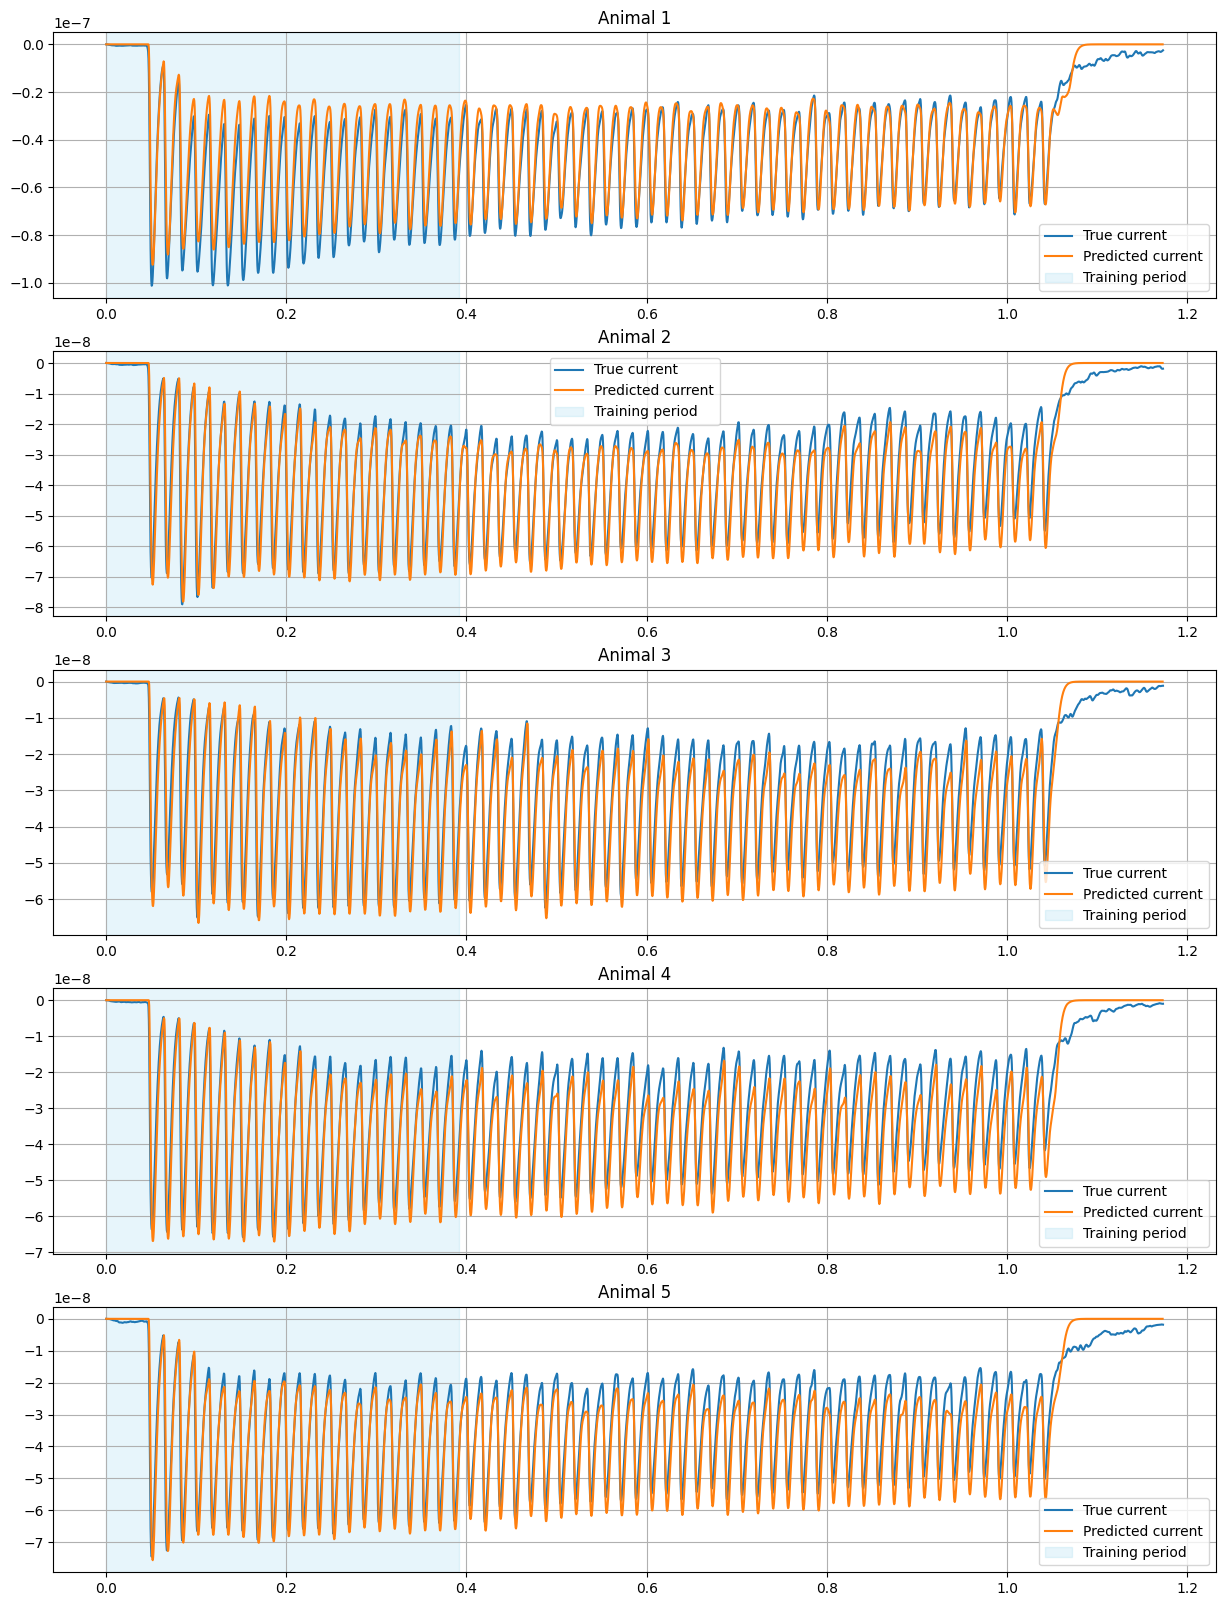

In [52]:
# Plot the resulting current
fig, axs = plt.subplots(figsize=(15, 20), nrows=5)

for idx in range(len(predicted_params)):
    ax = axs[idx]

    # Plot the currents
    ax.plot(times, list(currents.values())[idx], label='True current')

    # Plot the current
    ax.plot(times[:-1], calculate_current(R=pred_X[idx, :, Compartments["R"].value][:-1],
                                          k_F=predicted_params[idx][:, Parameters["F"].value],
                                          dt=dt,
                                          g=g_train,
                                          N=predicted_params[idx][:, Parameters["N"].value].mean()),
            label='Predicted current')

    ax.axvspan(training_start * dt, training_stop * dt, color='skyblue', zorder=-1, alpha=0.2, label='Training period')
    ax.legend()
    ax.grid()
    ax.set(title=f"Animal {idx+1}")